In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy.optimize import least_squares
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import math
# import astropy.units as u
from astropy.io.votable import parse
# from astropy.timeseries import LombScargle
import os
# from george import kernels
from datetime import datetime
# from astroquery.vizier import Vizier
# import exoplanet as xo
import theano.tensor as tt
import progressbar as pbar
import time

import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Reshape, \
                                                    Activation, BatchNormalization, UpSampling1D, \
                                                    UpSampling2D
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K
import tensorflow as tf

# Default graph settings
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams['legend.fontsize'] = 15

In [2]:
use_full_data = True

```SQL
SELECT
ra,                ra_error,
dec,               dec_error,
pmra,              pmra_error,
pmdec,             pmdec_error,
parallax,          parallax_error,
phot_g_mean_flux,  phot_g_mean_flux_error,
phot_bp_mean_flux, phot_bp_mean_flux_error,
phot_rp_mean_flux, phot_rp_mean_flux_error,
bp_rp,
bp_g,
g_rp,
radial_velocity,   radial_velocity_error,
teff_val,
a_g_val,
radius_val,
lum_val

FROM gaiadr2.gaia_source

WHERE
ra IS NOT NULL AND ra_error IS NOT NULL
AND dec IS NOT NULL AND dec_error IS NOT NULL
AND pmra IS NOT NULL AND pmra_error IS NOT NULL
AND pmdec IS NOT NULL AND pmdec_error IS NOT NULL
AND parallax IS NOT NULL AND parallax_error IS NOT NULL
AND phot_g_mean_flux IS NOT NULL AND phot_g_mean_flux_error IS NOT NULL
AND phot_bp_mean_flux IS NOT NULL AND phot_bp_mean_flux_error IS NOT NULL
AND phot_rp_mean_flux IS NOT NULL AND phot_rp_mean_flux_error IS NOT NULL
AND bp_rp IS NOT NULL
AND bp_g IS NOT NULL
AND g_rp IS NOT NULL
AND radial_velocity IS NOT NULL AND radial_velocity_error IS NOT NULL
AND teff_val IS NOT NULL
AND a_g_val IS NOT NULL
AND radius_val IS NOT NULL
AND lum_val IS NOT NULL
```

In [3]:
# all_data = parse('queries/query1_full.vot' if use_full_data
#                  else 'queries/query1_smallversion500k.vot')

data_path = 'queries/query1_full_no_errors.vot'

if not os.path.exists("queries/data.npz") or not os.path.exists("queries/data_feature_dict.npy"):
    print("Importing fresh data and parsing...")
    all_data = parse(data_path)
    d_table  = all_data.get_first_table()
    data     = np.array(d_table.array)
    
    feature_id_dict = {}
    i = 0
    for f in d_table.fields:
        print(f.ID)
        feature_id_dict[i] = f.ID
        feature_id_dict[f.ID] = i
        i += 1
    
    np.savez(open("queries/data.npz","wb"), data=data)
    np.save('queries/data_feature_dict.npy', feature_id_dict) 
else:
    print("Reloading data...")
    data = np.load(open("queries/data.npz","rb")).get('data')
    feature_id_dict = np.load('queries/data_feature_dict.npy',allow_pickle='TRUE').item()
    for f in feature_id_dict:
        if not isinstance(f, int):
            print(f)

Reloading data...
ra
dec
pmra
pmdec
parallax
phot_g_mean_flux
phot_bp_mean_flux
phot_rp_mean_flux
bp_rp
bp_g
g_rp
radial_velocity
teff_val
a_g_val
radius_val
lum_val


In [4]:
print("Total data points:", len(data))
num_fields = len(data[0])
print('Number of features per point:', num_fields)

Total data points: 4193907
Number of features per point: 16


In [5]:
# Split data into training, validation, and testing sets (~60/20/20)
x_train = []
x_test  = []
x_val   = []

for star in pbar.progressbar(data):
    s = np.array([float(i) for i in star])
    if (np.random.random() >= 0.6):
        if (np.random.random() >= 0.5):
            x_test.append(s)
        else:
            x_val.append(s)
    else:
        x_train.append(s)
        
x_train = np.array(x_train)
x_test  = np.array(x_test)
x_val   = np.array(x_val)
        
x_test_T = x_test.T

print(len(x_train), "training points,",
      len(x_val),   "validation points,",
      len(x_test),  "test points.")

100% (4193907 of 4193907) |##############| Elapsed Time: 0:00:59 Time:  0:00:59


2516530 training points, 838684 validation points, 838693 test points.


In [370]:
def reshape(dset):
    return np.reshape(np.array(dset), (len(dset), 1, num_fields))

# minmaxes arrays should always be a 2D array as such: [[all mins], [all maxes]]

def minMaxNormalize(value, minmaxes):
    return (value - minmaxes[0])/(minmaxes[1] - minmaxes[0])

def minMaxUnnormalize(value, minmaxes):
    return ((minmaxes[1] - minmaxes[0])*value) + minmaxes[0]

def normalizeSet(dset, minmaxes = None):
    if minmaxes is None:
        minmaxes = np.array([[min(ele), max(ele)] for ele in pbar.progressbar(dset.T)]).T
    set_norm = np.array([minMaxNormalize(star, minmaxes) for star in pbar.progressbar(dset)])
    return minmaxes, set_norm

def denormSet(dset, minmaxes):
    return np.array([minMaxUnnormalize(star, minmaxes) for star in pbar.progressbar(dset)])

In [366]:
x_train_minmaxes, x_train_norm = normalizeSet(x_train)
x_test_minmaxes,  x_test_norm  = normalizeSet(x_test, minmaxes = x_train_minmaxes) #normalize using scale of training data
x_val_minmaxes,   x_val_norm   = normalizeSet(x_val,  minmaxes = x_train_minmaxes)

# x_train_norm = reshape(x_train_norm)
# x_test_norm  = reshape(x_test_norm)
# x_val_norm   = reshape(x_val_norm)

100% (16 of 16) |########################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (2516372 of 2516372) |##############| Elapsed Time: 0:00:12 Time:  0:00:12
100% (839066 of 839066) |################| Elapsed Time: 0:00:04 Time:  0:00:04
100% (838469 of 838469) |################| Elapsed Time: 0:00:04 Time:  0:00:04


In [352]:
x_train_norm.shape

(2516372, 16)

In [354]:
batch_size       = 128
bottleneck_size  = 10

autoencoder = keras.Sequential(
                  [
                      Dense(16, activation="relu"),
                      BatchNormalization(),
                      Dropout(.1),
                      
                      Dense(15, activation="relu"),
                      BatchNormalization(),
                      Dropout(.1),
                      
                      Dense(15, activation="relu"),
                      BatchNormalization(),
                      Dropout(.1),
                      
                      Dense(14, activation="relu"),
                      BatchNormalization(),
                      Dropout(.1),
                      
                      Dense(13, activation="relu"),
                      BatchNormalization(),
                      
                      Dense(12, activation='relu'),
                      BatchNormalization(),

                      Dense(11, activation='relu'),
                      BatchNormalization(),
                      
                      Dense(bottleneck_size, activation='linear'),

                      Dense(11, activation='relu'),
                      BatchNormalization(),

                      Dense(12, activation='relu'),
                      BatchNormalization(),

                      Dense(13, activation='relu'),
                      BatchNormalization(),
                      
                      Dense(14, activation='relu'),
                      BatchNormalization(),
                      
                      Dense(15, activation='relu'),
                      BatchNormalization(),
                      
                      Dense(15, activation='relu'),
                      BatchNormalization(),

                      Dense(16, activation='relu'),
                      BatchNormalization(),

                      Dense(num_fields, activation='sigmoid')
                  ]
              )

In [392]:
def customLossFn(actual, predicted):
#     print(K.print_tensor(K.transpose(actual)))
#     loss = 0

    kl = tf.keras.losses.kl_divergence
    bin_x_ent = tf.keras.losses.binary_crossentropy
    
    actual = K.transpose(actual)
    predicted = K.transpose(predicted)
    
#     return kl(actual, predicted) + bin_x_ent(actual, predicted)
    return bin_x_ent(actual, predicted)

#     for feature in range(len(actual[0])):
#         loss += kl(K.transpose(actual)[0][i], K.transpose(predicted)[0][i])
#     loss = shared(np.array([kl_loss] * actual.ndim))
#     print(loss)
#     return loss

def step_decay_lrate(initial_lrate, drop, epochs_drop):
    def lrate(epoch):
        return initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return LearningRateScheduler(lrate)

In [ ]:
def customLossFn(actual, predicted):

    kl = tf.keras.losses.kl_divergence
    bin_x_ent = tf.keras.losses.binary_crossentropy
    
    return kl(actual, predicted) + bin_x_ent(actual, predicted)

In [393]:
model_desc = '16-16-15-15-14-13-12-11-10-11-12-13-14-15-15-16-16'

In [394]:
logdir = os.path.join("nn_results", datetime.now().strftime("%Y%m%d-%H%M%S"))
run_time_string = datetime.utcnow().isoformat(timespec='minutes')

model_path = f'nn_results/gaia_v1_autoencoder_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                 monitor='val_loss', 
                                                 save_best_only=True, 
                                                 mode='min',
                                                 verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
                                                      histogram_freq = 0, 
                                                      write_graph = True, 
                                                      write_grads = False, 
                                                      write_images = False, 
                                                      embeddings_freq=0, 
                                                      embeddings_layer_names=None, 
                                                      embeddings_metadata=None,
                                                      embeddings_data=None)

# autoencoder.compile(optimizer='adam', loss=['binary_crossentropy', tf.keras.losses.KLDivergence()])
autoencoder.compile(optimizer='adam', loss=customLossFn)

autoencoder_train = autoencoder.fit(x_train_norm, x_train_norm, 
                                    batch_size=batch_size,epochs=50,
                                    verbose=1, shuffle=False, 
                                    validation_data=(x_val_norm, x_val_norm),
                                    callbacks=[step_decay_lrate(0.01, 0.4, 5.0),
                                                tensorboard_callback,
                                                model_check],
                                    initial_epoch=0)

Training ... nn_results/gaia_v1_autoencoder_nn_2020-08-26T21:36.h5
Epoch 1/50
19656/19660 [============================>.] - ETA: 0s - loss: 0.3753
Epoch 00001: val_loss improved from inf to 0.36900, saving model to nn_results/gaia_v1_autoencoder_nn_2020-08-26T21:36.h5
19660/19660 [==============================] - 56s 3ms/step - loss: 0.3753 - val_loss: 0.3690
Epoch 2/50
19642/19660 [============================>.] - ETA: 0s - loss: 0.3734
Epoch 00002: val_loss improved from 0.36900 to 0.36884, saving model to nn_results/gaia_v1_autoencoder_nn_2020-08-26T21:36.h5
19660/19660 [==============================] - 61s 3ms/step - loss: 0.3734 - val_loss: 0.3688
Epoch 3/50
19648/19660 [============================>.] - ETA: 0s - loss: 0.3733
Epoch 00003: val_loss did not improve from 0.36884
19660/19660 [==============================] - 58s 3ms/step - loss: 0.3733 - val_loss: 0.3692
Epoch 4/50
19655/19660 [============================>.] - ETA: 0s - loss: 0.3733
Epoch 00004: val_loss did no

KeyboardInterrupt: 

In [226]:
# autoencoder.load_weights('nn_results/gaia_v1_autoencoder_nn_2020-08-19T2112.h5')

In [380]:
def graphFeatures(predicted, use_xlims = True):
    # xlims = {
    #     "ra_error"   : [0,0.1],
    #     "dec_error"  : [0,0.1],
    #     "pmra"       : [-250,250],
    #     "pmra_error" : [0,0.25],
    #     "pmdec"      : [-100,100],
    #     "pmdec_error": [0,0.2],
    #     "parallax"   : [0,10],
    #     "parallax_error" : [0,0.1],
    #     "phot_g_mean_flux" : [-.1e6,4e6],
    #     "phot_g_mean_flux_error" : [-1500,1500],
    #     "phot_bp_mean_flux" : [-.1e6,2e6],
    #     "phot_bp_mean_flux_error" : [-1500,1500],
    #     "phot_rp_mean_flux" : [-.1e6,2e6],
    #     "phot_rp_mean_flux_error" : [-1500,1500],
    #     "radial_velocity" : [-200,200],
    #     "radial_velocity_error" : [0,7.5],
    #     "radius_val" : [0,50],
    #     "lum_val" : [0,300]
    # }

    xlims = {
        "dec"        : [-100,100],
        "pmra"       : [-100,100],
        "pmdec"      : [-75,75],
        "parallax"   : [0,10],
        "phot_g_mean_flux"  : [-.1e6,4e6],
        "phot_bp_mean_flux" : [-.1e6,2e6],
        "phot_rp_mean_flux" : [-.1e6,2e6],
        "radial_velocity" : [-200,200],
        "radius_val" : [0,50],
        "lum_val"    : [0,300]
    }

    def compareFeatureDistr(mainPlot, use_xlims = True, f_name = None, f_id = None,
                            label = False, bins = 70, kde = False):
        if f_id is None and f_name is None: raise Exception
        elif f_id is None: feature_id = feature_id_dict[f_name]
        elif f_name is None: f_name = feature_id_dict[f_id]

        mainPlot.flat[f_id].set_title(f_name, fontsize=20, pad=10)
        mainPlot.flat[f_id].set(xlabel=f_name, ylabel='')

        if f_name in xlims and use_xlims:
            mainPlot.flat[f_id].set_xlim(xlims[f_name])
            if bins is not None:
                binwidth = (xlims[f_name][1] - xlims[f_name][0]) / bins
                bins = np.arange(xlims[f_name][0], xlims[f_name][1] + binwidth, binwidth)

        sns.distplot(predicted.T[f_id], ax=mainPlot.flat[f_id], label="Model Distribution" if label else None,
                    bins = bins, kde = kde)
        sns.distplot(x_test.T[f_id], ax=mainPlot.flat[f_id], label="Actual Distribution" if label else None,
                    bins = bins, kde = kde)

        if f_name in xlims and use_xlims: mainPlot.flat[f_id].set_xlim(xlims[f_name])

    fig, mainPlot = plt.subplots(math.ceil(num_fields/2), 2,figsize=(15,45))
    fig.suptitle("Actual vs Model Feature Distributions on x_test", fontsize=25, y=.95)

    for i in range(num_fields):
        if i == 0: compareFeatureDistr(mainPlot, use_xlims, f_id = i, label = True)
        else: compareFeatureDistr(mainPlot, use_xlims, f_id = i)

    plt.subplots_adjust(top=0.92, bottom=0.1, left=0.10, right=0.95, hspace=0.6, wspace=0.2)    
    fig.legend()
    plt.show()

    fig.savefig('feature_distr_noerr_' + model_desc + '_' + time.strftime("%Y%m%d-%H%M%S") + '.png', quality=100)

In [395]:
predicted = denormSet(autoencoder.predict(x_test_norm), x_train_minmaxes)

100% (839066 of 839066) |################| Elapsed Time: 0:00:07 Time:  0:00:07


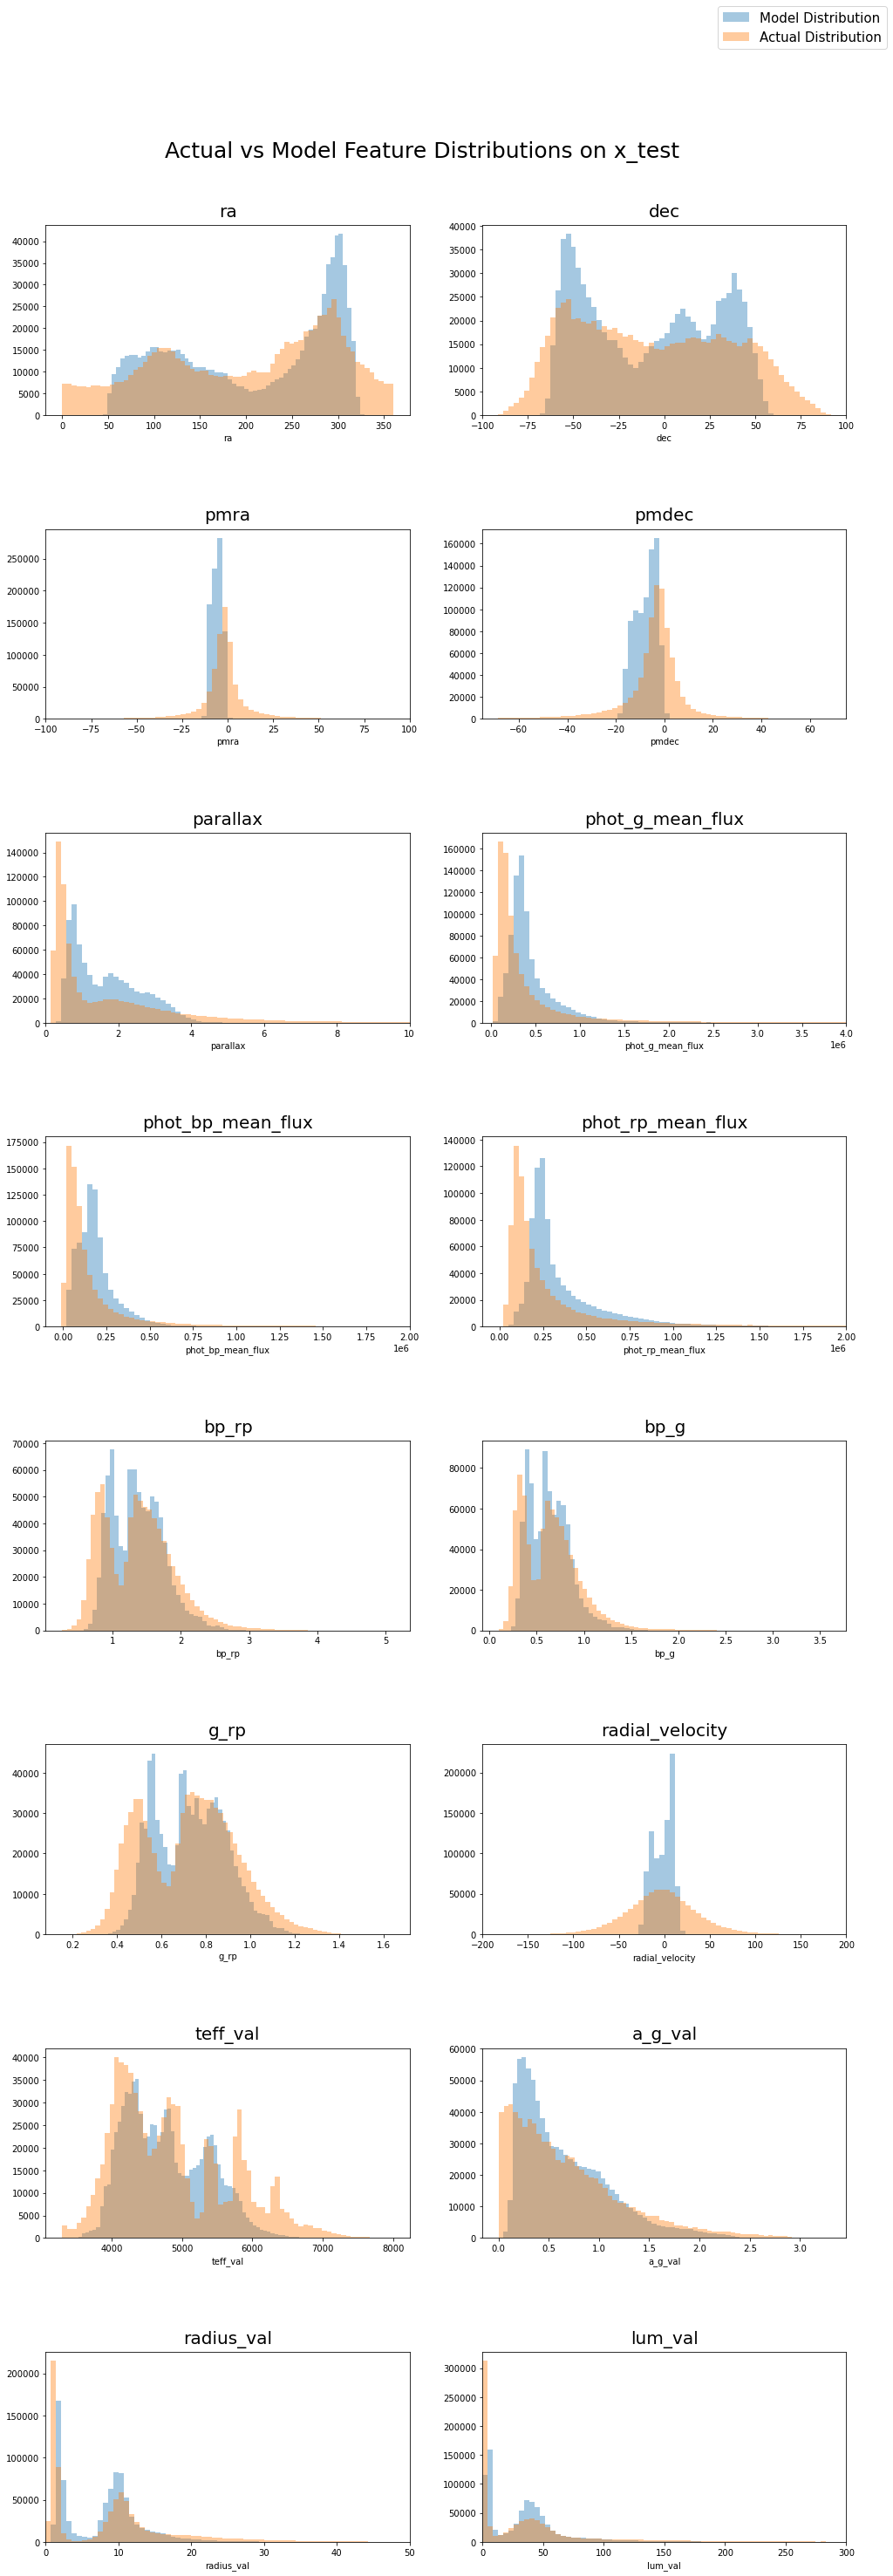

In [396]:
graphFeatures(predicted, use_xlims = True)

In [305]:
np.save('queries/data_feature_dict.npy', feature_id_dict) 

In [375]:
x_test[34]

array([ 2.45823484e+02,  1.54736822e+01, -1.00513366e+01,  6.79512685e+00,
        2.72734411e+00,  5.24404998e+05,  3.01585055e+05,  3.23343921e+05,
        6.65104866e-01,  2.63665199e-01,  4.01439667e-01, -2.94191210e+01,
        6.39466992e+03,  2.30000004e-01,  1.34599376e+00,  2.72931314e+00])

In [376]:
predicted[34]

array([ 2.64443453e+02,  1.74810758e+01, -2.27069658e+00, -6.93395746e+00,
        2.92391056e+00,  4.28386787e+05,  2.26214804e+05,  2.91011272e+05,
        8.36158050e-01,  3.41042411e-01,  4.95721138e-01, -1.02451947e+01,
        5.76763408e+03,  3.21723829e-01,  1.28735019e+00,  2.36969233e+00])